批量归一化 Batch Norm
- 数据在下面，损失函数在上面，会有什么问题呢？
- 在自动求导的时候讲过，正向的时候由下往上一直一直往上走，forward函数，backward的时候其实是从上面一直往下，问题是什么？梯度在上面的时候会比较大，越到下面就越任意变小，很多时候是n个很小的数相乘，乘到最后梯度就很小了。梯度爆炸是另一回事，正常情况下梯度都是比较小的值。越靠近数据的话，那些层的梯度就会变小。
- 他的问题是说上面的层的梯度比较大，每次更新的时候上面的梯度就会不断地去更新，因为学习率大家就是一个值。但是下面层因为梯度比较小，对权重的更新就比较小。问题就是上面的东西很快就会收敛，下面的东西会比较慢，每一次更新下面靠近数据的东西，比较常抽取底层的特征，比如局部的边缘和很简单的纹理信息，上面是比较高层级的信息，但是上面虽然训练好了，但下面一变上面还是得重新训练，上面的权重就白学了。
- 导致一个问题，底部变化慢，顶部变化快，顶部不断重新训练，重新去拟合底部变化的问题。导致收敛比较慢。所以我们能不能在改变底部的时候，能够避免顶部不断的重复训练。
- 损失出现在最后，后面的层训练较快
- 数据在最底层
- 底部的层训练较慢
- 底部层一变化，所有都得跟着变
- 最后的那些层需要重复训练多次
- 导致收敛变慢
- 我们可以在学习底部层的时候避免变化顶部层吗？

批量归一化
- 回忆之前将损失和数值稳定性里，为什么会变，因为方差和均值整个分布会在不同层直接变化，那么一个简单办法是假设把分布给固定住了，不管每一层输出和梯度都符合某个分布，相对来说他比较稳定。分布具体的东西可以细调。
- 批量归一化是一个很简单的思想，就是说尝试把一个小批量mini batch里面，在不同层不同地方的mini batch里面进去他的输出，把他的均值和方差固定住。
- 固定小批量里面的均值和方差
- miu_B = 1/|B| sum_iEB xi
- sigma_B ^ 2 = 1/|B| sum_iEB (x_i - miu_B)^2 + eps
- B是所有小批量下边的索引，对小批量的所有样本求和，再除以批量大小。简单假设xi就是向量。
- 方差就是xi减去均值平方求和平均，再加上一个很小的数。
- 然后再做额外的调整（可学习的参数）
- x_i+1 = gamma (x_i - miu_B)/sigma_B + beta
- miu_B和sigma_B就是根据当前数据算出来的
- gamma方差，beta均值，gamma和beta是可以学习的参数，批量归一化给他学出来的
- 假设分布变成均值0方差1的分布不太适合的话，我可以去学习一个新的均值和方差，使得值对神经网络更好一点。限制住gamma和beta的变化不要特别猛烈。

批量归一化层
- 可以学习的参数为gamma和beta
- 对每一个特征，如果是全连接的话对于每一列，有一个gamma和beta
- 作用在
- 全连接层和卷积层输出上，他会作用在激活函数前
- 全连接层和卷积层输出后，直接接上一个批量归一化层，均值一减，方差一除，再加上一个可以学习的gamma和beta，再做激活函数
- 放在relu之前，省的relu把所有东西变成正数，批量归一化是个线性变换，是个线性的
- 全连接层和卷积层输入上
- 可以对输入做个线性变化
- 对全连接层，作用在特征维
- 输入是个二维输入，每一行是样本，每一列是特征，对全连接层，是对每一个特征计算一个标量的均值和标量的方差，变成均值为0，方差为1。这里不一样的是对每一个全连接层的输入和输出都做这个事情，而不是只作用在数据上。然后在学到的gamma和beta上，再做一次矫正。
- 对于卷积层，作用在通道维
- 思想看到过很多次，特别是1x1的卷积层等价于全连接层。我们说等价的意思，其实是说对每个像素，他不是有多通道吗，对每个像素，通道数是100的话，这个像素是有个长为100的向量，那么可以认为这个向量是这个像素的一个特征。那么你可以认为，对于输入有高宽来说，里面的每一个像素就是一个样本。
- 所以对于一个卷积层来讲，假设输入是批量大小x高x宽x通道数的话，那么你的样本数就是批量大小x高x宽，整个批量里所有的像素都是你的样本，那么他对应的通道就是你的特征。1x1的卷积就是把他拉成一个2维矩阵后再做一个全连接。通道层当作是卷积层的特征维。

批量归一化在做什么？
- 最初论文是想用他来减少内部协变量转移
- 例如，我用当前的数据去拟合明天的话，疫情前的数据来预测疫情后，世界已经变了，covariance shift，模型肯定会有问题。批量归一化想来减少covariance shift。计算协变量后发现并没有减少。
- 后续有论文指出他可能就是通过在每个小批量里加入噪音来控制模型复杂度
- 效果好可能本质上是加入了噪音。miu_B是随机偏移，sigma_B是随机缩放，这两个是噪音。随机的均值和随机方差，因为是随机的样本，所以均值是当前的样本的均值和方差，所以噪音是比较大的。然后一减一除，相当于是做了一些随机的均值转移和方差变化。gamma和beta是可以学的东西，每次减去一个learning rate，变化不会很剧烈。变化不剧烈，也有一定的随机性。可以被认为是在每个小批量加入噪音来控制模型复杂度。
- x_i+1 = gamma (x_i - miu_B)/sigma_B + beta
- 这个东西可能也是不对的，工程走在了理论的前面。
- 因此没必要跟丢弃法混合使用。批量归一化后再加dropout可能就没那么有用了。

总结
- 批量归一化固定小批量中的均值和方差，然后学习出适合的偏移和缩放
- 可以**加速收敛速度**，但一般不改变模型精度，学习率可以调大，速度更快






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install d2l==0.17.6

In [ ]:
import os
path = '/content/drive/MyDrive'
os.chdir(path)

!source venv_d2l/bin/activate

path = '/content/drive/MyDrive/d2l-zh'
os.chdir(path)

In [ ]:
# 从零实现

import torch
from torch import nn
from d2l import torch as d2l

# batch normalization，先实现这个函数，再实现层
# 输入X是这个层的输入，y就是我的输出；gamma和beta是可以学的parameter
# moving_mean和moving_var是全局的均值和方差，做inference推理的时候用的，近似认为是整个数据集上的均值和方差，而不是小批量上的均值和方差
# eps就是避免除以0的东西，通常有个值的，一般不要更改；momentum用来更新moving_mean和moving_var的东西，通常取0.9或者一个固定的数字
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 不要算梯度，指的是做inference的情况下；推理不需要反向传播，所以不需要计算梯度
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        # inference的时候之所以不用批量的均值是因为可能就一个样本进来，根本算不出来，所以要用全局的
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        # 训练模式
        # X.shape要么等于2，是全连接层；要么等于4，是卷积层
        # 全连接层：批量数+特征数=2，batch size feature；卷积层：批量数+通道数+图片高+图片宽=4 batch size channels height weight
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            # 均值按行求均值，每一列算一个均值出来，1xn的行向量；方差也是一个行向量
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 2D Conv
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            # dim 0 批量大小，1 输出通道，2和3是高和宽
            # 按通道数来求均值，求出来是1xnx1x1的4D的东西
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        # 当前的移动均值*0.9，再加上0.1*当前算的均值，这是moving的一个smooth的版本，做inference不会更新他，只有训练的时候会更新他
        # 0.9*moving_mean + 0.1*mean
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    # 返回的是对X做过变换的Y，是个线性变换，再加上moving的mean和var；如果是torch的话返回对应的data，gradient不重要
    return Y, moving_mean.data, moving_var.data

In [ ]:
# 创建一个正确的BatchNorm图层
# 输入feature的个数和number of dimensions 这里是2或4
# 为什么要定义这个shape？是因为gamma、beta、moving_mean、moving_var都要长成这个shape
# 特别是gamma初始化全1，不能等于0，否则一乘就全等于0了
# gamma需要去拟合的方差，beta需要去拟合的均值，gamma和beta是需要去迭代的， 所以gamma和beta放在一个nn.Parameter里面
# 放在nn.Parameter里面的变量，会随着网络的优化器一起更新迭代

class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    # 因为moving_mean和moving_var没有放在nn.Parameter里面，所以导致说我得自己去算一个device，forward函数里
    # 如果device不等于输入的device的话，那么就把moving_mean和moving_var挪到我的device上，挪到GPU上
    # 然后调用刚才定义的函数；eps每个框架要保证一致1e-5，1e-6，1e-7；momentum都是0.9
    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [ ]:
# 应用BatchNorm于LeNet模型
# 在第一个卷积后面加了一个batch norm，因为输入是卷积dims=4，features是输入通道数6
# 同样的第二个卷积层后也加一个batch norm，注意是加在sigmoid激活函数的前面
# 同样的线性层后面也加上batch norm，最后输出就不用线性变换了
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.277, train acc 0.897, test acc 0.834
15428.0 examples/sec on cuda:0


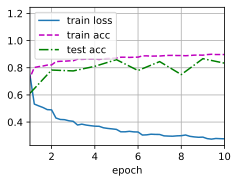

In [ ]:
# 感觉上收敛变快了
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
# 拉伸参数gamma和偏移参数beta
# net[1]是第一个batch norm，6个通道学出来的方差和均值，很深的时候看最底层和最上面是否长得一样
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([0.3260, 3.7871, 3.7556, 1.1624, 3.6314, 0.8488], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([-0.4959, -1.9525, -1.7203,  1.0883, -3.7371, -1.4018], device='cuda:0',
        grad_fn=<ViewBackward0>))

In [ ]:
# 简明实现 BatchNorm2d和BatchNorm1d
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.264, train acc 0.902, test acc 0.819
29926.0 examples/sec on cuda:0


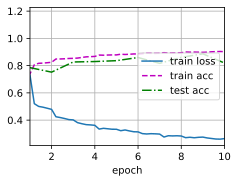

In [ ]:
# 使用相同超参数来训练模型
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

QA
- 之前Xavier是使得初始的时候稳定，不能保证之后稳定；batch norm保证强行归一化normalization，方差变1均值变0；Xavier是正则regularization
- batch norm可以用在MLP，但是对深度神经网络有用，对LeNet没太大用处
- batch norm和线性层的区别：线性层不一定能学到同样的东西，不做均值变0方差变1，很可能数值不稳定，根本训练不到好的值里去。
- 收敛时间变短：BN本身会使得梯度值变大一点点，导致可以使用更大的学习率，导致权重的更新变快。epochs数可以大一点，batch size不能大不能小，根据内存来，然后再调学习率。框架是用惯一个就不换，都差不多。
- batch norm是对在feature维度对样本做normalization；layer norm是在样本里面的feature做normalization
- 增加batch size发现每秒处理的example没有变大为止
